In [666]:
import cv2
import scipy.stats.qmc as qmc
import scipy
import matplotlib.pyplot as plt 
import numpy as np
import pickle
from collections import Counter
import random
from manim import *
import scipy.stats.qmc as qmc
import os

In [667]:
def import_UV_from_file(file_U, file_V):
    with open(file_U, 'rb') as inp:
        U = np.real(pickle.load(inp))
    with open(file_V, 'rb') as inp:
        V = np.real(pickle.load(inp))
    return U, V

def generate_random_UV(sz):
    U = np.random.random(sz)
    V = np.random.random(sz)
    return U,V

def generate_UV_training(sz):
    U = np.zeros(sz)
    V = np.zeros(sz)

    x_ordinates = np.arange(sz[1])
    y_ordinates = np.arange(sz[0])
    #Create a meshgrid
    X, Y = np.meshgrid(x_ordinates, y_ordinates)
    r1 = np.random.randint(0,sz[0])
    r2 = np.random.randint(0,sz[1])
    r3 = np.random.randint(0,sz[0])
    r4 = np.random.randint(0,sz[1])
    R1 = np.sqrt((X-r1)**2+(Y-r2)**2)
    # R2 = np.sqrt((X-r3)**2+(Y-r4)**2)
    U = np.exp(-R1/50)
    V = np.exp(-R1/50)

    return U,V




# im = cv2.imread('../res/starry_night_crop.jpg')
# im = cv2.colorChange(im, None, cv2.COLOR_RGB2BGR)

In [668]:
def backtrace(coordinates_x, coordinates_y, velocity_x_prev, velocity_y_prev, dt, aspect_ratio):
  velocity_x_prev = np.copy(velocity_x_prev)
  velocity_y_prev = np.copy(velocity_y_prev)
  nx = np.shape(coordinates_x)[1]
  ny = np.shape(coordinates_x)[0]
  #First, get the backtraced coordinates (if you follow the streamline
  #back, where do we go?)
  backtraced_coordinates_x = coordinates_x - dt * velocity_x_prev
  backtraced_coordinates_y = coordinates_y - dt * velocity_y_prev

  #The reference tells us the matrix index of the matrix we need to select
  backtraced_reference_x = backtraced_coordinates_x / aspect_ratio * nx
  backtraced_reference_x_low = np.floor(backtraced_reference_x)
  backtraced_reference_x_high = np.ceil(backtraced_reference_x)
  linear_const_x = backtraced_reference_x - backtraced_reference_x_low
  
  # backtraced_reference_x_low = np.clip(backtraced_reference_x_low, 0, nx-1)
  # backtraced_reference_x_high = np.clip(backtraced_reference_x_high, 0, nx-1)
  backtraced_reference_x_low = backtraced_reference_x_low % nx
  backtraced_reference_x_high = backtraced_reference_x_high % ny

  backtraced_reference_y = backtraced_coordinates_y * ny
  backtraced_reference_y_low = np.floor(backtraced_reference_y)
  backtraced_reference_y_high = np.ceil(backtraced_reference_y)
  linear_const_y = backtraced_reference_y - backtraced_reference_y_low

  # backtraced_reference_y_low = np.clip(backtraced_reference_y_low, 0, ny-1)
  # backtraced_reference_y_high = np.clip(backtraced_reference_y_high, 0, ny-1)

  backtraced_reference_y_low = backtraced_reference_y_low % ny
  backtraced_reference_y_high = backtraced_reference_y_high % ny

  #Need to reshape the velocity matrix to account for the fact that we can
  #only index a vector not a matrix
  velocity_x_row = np.reshape(velocity_x_prev,[np.size(velocity_x_prev)])
  velocity_y_row = np.reshape(velocity_y_prev,[np.size(velocity_y_prev)])

  #Need to amend the referencing to account for the fact it is a vector not
  #a matrix.
  low_low_index = np.int32((backtraced_reference_x_low)+(backtraced_reference_y_low)*nx)
  low_high_index = np.int32((backtraced_reference_x_low)+(backtraced_reference_y_high)*nx)
  high_low_index = np.int32((backtraced_reference_x_high)+(backtraced_reference_y_low)*nx)
  high_high_index = np.int32((backtraced_reference_x_high)+(backtraced_reference_y_high)*nx)

  #Complete interpolation for backtracing
  velocity_x = velocity_x_row[low_low_index]* (1-linear_const_x)*(1-linear_const_y) + velocity_x_row[low_high_index]* (1-linear_const_x)*(linear_const_y) + velocity_x_row[high_low_index]* (linear_const_x)*(1-linear_const_y) + velocity_x_row[high_high_index]* (linear_const_x)*(linear_const_y)
  velocity_y = velocity_y_row[low_low_index]* (1-linear_const_x)*(1-linear_const_y) + velocity_y_row[low_high_index]* (1-linear_const_x)*(linear_const_y) + velocity_y_row[high_low_index]* (linear_const_x)*(1-linear_const_y) + velocity_y_row[high_high_index]* (linear_const_x)*(linear_const_y)

  return (velocity_x, velocity_y)

In [669]:
def zero_mean_velocity(velocity_x, velocity_y):
  velocity_x = np.copy(velocity_x)
  velocity_y = np.copy(velocity_y)
  #Subtract Mean
  velocity_x = velocity_x - np.mean(velocity_x)
  velocity_y = velocity_y - np.mean(velocity_y)

  return (velocity_x, velocity_y)

In [670]:
def diffuse_incompressible(velocity_x, velocity_y, decay, normalized_wavenumbers_x, normalized_wavenumbers_y):
    velocity_x = np.copy(velocity_x)
    velocity_y = np.copy(velocity_y)

    n_points_y = np.shape(velocity_x)[0]
    n_points_x = np.shape(velocity_x)[1]

    #Transform Into Fourier
    velocity_x_fft = np.fft.fft2(velocity_x)
    velocity_y_fft = np.fft.fft2(velocity_y)
    
    #Low Pass Filter
    velocity_x_fft = velocity_x_fft * decay
    velocity_y_fft = velocity_y_fft * decay
    
    #Compute Pseudo Pressure
    pressure_fft = velocity_x_fft * normalized_wavenumbers_x + velocity_y_fft * normalized_wavenumbers_y
    
    #Project Velocities to be Incompressible
    velocity_x_fft = velocity_x_fft - pressure_fft * normalized_wavenumbers_x
    velocity_y_fft = velocity_y_fft - pressure_fft * normalized_wavenumbers_y
    #Transform Into Spatial
    velocity_x = np.real(np.fft.ifft2(velocity_x_fft, [n_points_y, n_points_x]));
    velocity_y = np.real(np.fft.ifft2(velocity_y_fft, [n_points_y, n_points_x]));

    return (velocity_x, velocity_y)

In [671]:
def curl_fft_UV(U,V, wavenumbers_x, wavenumbers_y):
    d_u_d_y_fft = 1j * wavenumbers_y * np.fft.fft2(U)
    d_v_d_x_fft = 1j * wavenumbers_x * np.fft.fft2(V)
    curl_fft = d_v_d_x_fft - d_u_d_y_fft
    return curl_fft
def curl_diagram(curl_fft, sz):
    curl = np.fft.ifft2(curl_fft, sz)
    curl = np.real(curl)
    return curl

In [672]:
#HYPERPARAMETERS
U,V = import_UV_from_file("../out/U.pkl", "../out/V.pkl")

sz = np.shape(U)
nu = 1/50
dt = 0.1
n_iter = 301

n_points_y = sz[0]
n_points_x = sz[1]

aspect_ratio = n_points_x/n_points_y
coordinates_x = np.ones([n_points_y,1]) @ np.array([np.arange(start = 0, stop = aspect_ratio,step = aspect_ratio/n_points_x)])#linspace(0,aspect_ratio, n_points_x);
coordinates_y = np.array([np.arange(0,1,1/n_points_y)]).T * np.ones([1,n_points_x])

indices_x = np.arange(0, n_points_x)
indices_y = np.arange(0, n_points_y)
matrix_indices_x, matrix_indices_y = np.meshgrid(indices_x, indices_y)

wavenumbers_1d_x = np.fft.fftfreq(n_points_x)
wavenumbers_1d_y = np.fft.fftfreq(n_points_y)
#wavenumbers_1d_x = [0:((n_points_x - rem(n_points_x,2))/2-1), -((n_points_x - rem(n_points_x,2))/2):-1];
n_fft_points_x = np.shape(wavenumbers_1d_x)[0]
#wavenumbers_1d_y = [0:((n_points_y - rem(n_points_y,2))/2-1), -((n_points_y - rem(n_points_y,2))/2):-1];
n_fft_points_y = np.shape(wavenumbers_1d_y)[0]

wavenumbers_x = np.ones([n_fft_points_y,1]) @ np.array([wavenumbers_1d_x])
wavenumbers_y = np.array([wavenumbers_1d_x]).T @ np.ones([1,n_fft_points_x])
wavenumbers_x_squared = wavenumbers_x * wavenumbers_x
wavenumbers_y_squared = wavenumbers_y * wavenumbers_y
wavenumbers_norm = np.sqrt(wavenumbers_x_squared + wavenumbers_y_squared)

decay = np.exp(-dt * nu * wavenumbers_norm * wavenumbers_norm)
wavenumbers_norm[wavenumbers_norm==0] = 1
normalized_wavenumbers_x = wavenumbers_x / wavenumbers_norm
normalized_wavenumbers_y = wavenumbers_y / wavenumbers_norm


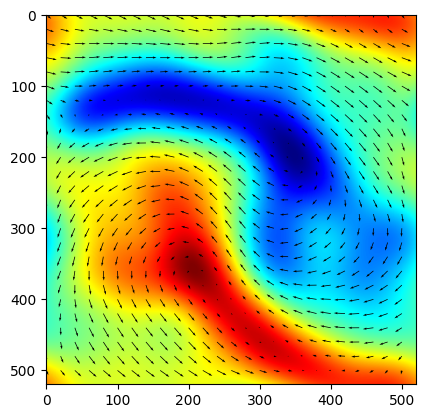

In [673]:
U, V = import_UV_from_file('../out/U.pkl', '../out/V.pkl')

indices_x = np.arange(0, np.shape(U)[1])
indices_y = np.arange(0, np.shape(V)[0])
matrix_indices_x, matrix_indices_y = np.meshgrid(indices_x, indices_y)

#Progress in Time
velocity_x_prev = np.copy(U)
velocity_y_prev = np.copy(V)
if (30%30==0):
    diagram = curl_diagram(curl_fft_UV(U, V, wavenumbers_x=wavenumbers_x, wavenumbers_y = wavenumbers_y), sz)
    diagram_color = cv2.applyColorMap(np.uint8((diagram-np.min(diagram))/(np.max(diagram)-np.min(diagram))*255), cv2.COLORMAP_JET)
    subsample = 20
    mask_1 = np.logical_not(np.bool8(np.ma.masked_where(matrix_indices_x % subsample != 0, matrix_indices_x)).mask)
    mask_2 = np.logical_not(np.bool8(np.ma.masked_where(matrix_indices_y % subsample != 0, matrix_indices_y)).mask)

    mask = (np.logical_and(mask_1, mask_2))
    shape_of_masked = np.size(matrix_indices_x[mask])
    # print(mask)
    
    plt.quiver(matrix_indices_x[mask], matrix_indices_y[mask], U[mask], -V[mask],  color='black', scale=30, width=0.002)
    plt.imshow(diagram_color)
    plt.show()
    # cv2.imwrite("../out/curls_art/img"+'{:03}'.format(int(0))+'-'+'{:03}'.format(int(iter/10))+'.jpg',diagram_color)

In [674]:
def progress_in_time(U, V, save_name):
    velocity_x = U
    velocity_y = V

    velocity_x_prev = np.zeros([n_points_y, n_points_x])
    velocity_y_prev = np.zeros([n_points_y, n_points_x])
    velocity_x_prev = U
    velocity_x_prev[np.isnan(velocity_x_prev)] = 0
    velocity_y_prev = V
    velocity_y_prev[np.isnan(velocity_y_prev)] = 0

    for iter in range(n_iter):
        #Progress in Time
        velocity_x_prev = np.copy(velocity_x)
        velocity_y_prev = np.copy(velocity_y)
        if (iter%300==0):
            diagram = curl_diagram(curl_fft_UV(velocity_x, velocity_y, wavenumbers_x=wavenumbers_x, wavenumbers_y = wavenumbers_y), sz)
            diagram_color = cv2.applyColorMap(np.uint8((diagram-np.min(diagram))/(np.max(diagram)-np.min(diagram))*255), cv2.COLORMAP_JET)
            plt.imshow(diagram_color)
            subsample = 10
            mask_1 = np.logical_not(np.bool8(np.ma.masked_where(matrix_indices_x % subsample != 0, matrix_indices_x)).mask)
            mask_2 = np.logical_not(np.bool8(np.ma.masked_where(matrix_indices_y % subsample != 0, matrix_indices_y)).mask)

            mask = (np.logical_and(mask_1, mask_2))
            shape_of_masked = np.size(matrix_indices_x[mask])
            # print(mask)
            
            plt.quiver(matrix_indices_x[mask], matrix_indices_y[mask], velocity_x[mask], -velocity_y[mask],  color='black')
            plt.show()
            cv2.imwrite("../out/curls_art/img"+'{:03}'.format(int(save_name))+'-'+'{:03}'.format(int(iter/10))+'.jpg',diagram_color)

        velocity_x, velocity_y = backtrace(coordinates_x, coordinates_y, velocity_x_prev, velocity_y_prev, dt, aspect_ratio)

        velocity_x, velocity_y = zero_mean_velocity(velocity_x, velocity_y)

        velocity_x, velocity_y = diffuse_incompressible(velocity_x, velocity_y, decay, normalized_wavenumbers_x, normalized_wavenumbers_y)

        velocity_x, velocity_y = zero_mean_velocity(velocity_x, velocity_y)

    return velocity_x, velocity_y

In [675]:
def validate(U,V):
    gradients = np.zeros([2**7])
    polarities = np.zeros([2**7])
    generator = qmc.Sobol(2,bits=7)
    seeds = np.uint64(generator.random_base2(m=7)*np.flip(sz))
    for row in range(np.shape(seeds)[0]):
        gradients[row] = V[seeds[row,0],seeds[row,1]] / U[seeds[row,0],seeds[row,1]]
        polarities[row] = np.sign(V[seeds[row,0],seeds[row,1]])
    return seeds, gradients, polarities

In [676]:
def generate_validation_set(numvals):
    for i in range(numvals):
        U, V = generate_UV_training(sz)
        U, V = progress_in_time(U, V, i)
        seeds, gradients, polarities = validate(U,V)
        if (not os.path.exists('../out/validation'+'{:03}'.format(i))):
            os.mkdir('../out/validation'+'{:03}'.format(i))
        with open('../out/validation'+'{:03}'.format(i)+'/seeds.pkl', 'wb') as outp:
            pickle.dump(seeds, outp, pickle.HIGHEST_PROTOCOL)
        with open('../out/validation'+'{:03}'.format(i)+'/gradients.pkl', 'wb') as outp:
            pickle.dump(gradients, outp, pickle.HIGHEST_PROTOCOL)
        with open('../out/validation'+'{:03}'.format(i)+'/polarities.pkl', 'wb') as outp:
            pickle.dump(polarities, outp, pickle.HIGHEST_PROTOCOL)


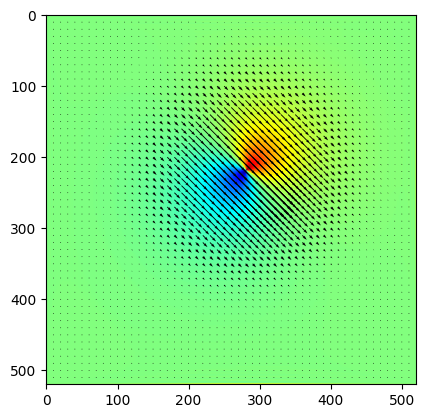

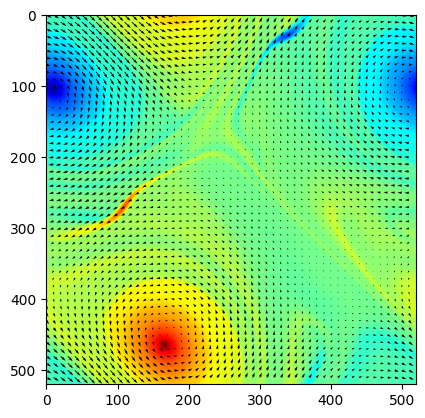

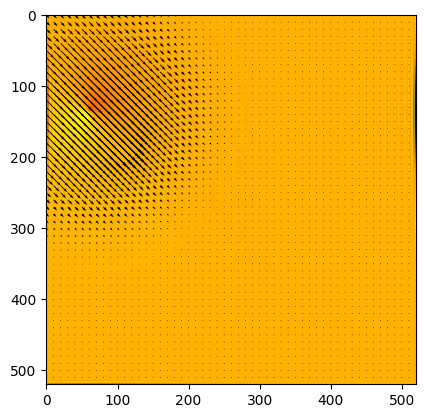

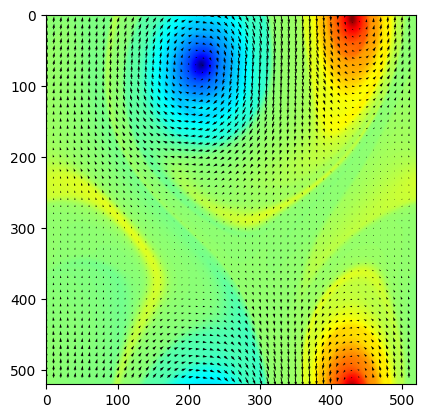

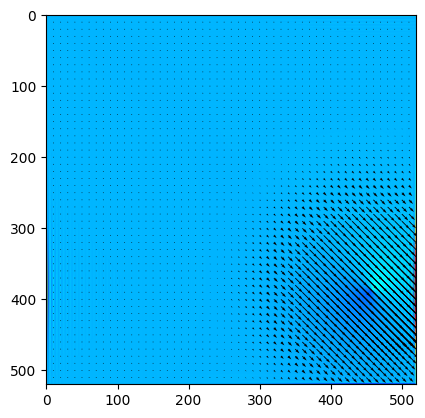

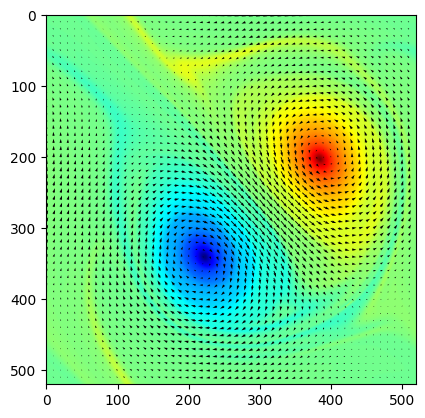

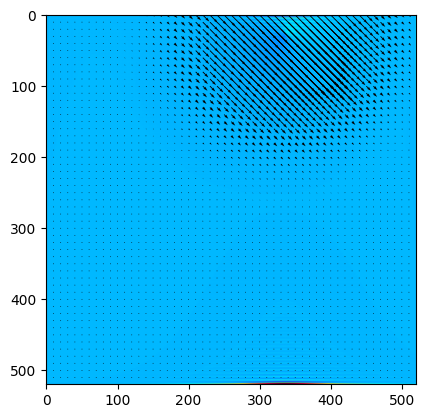

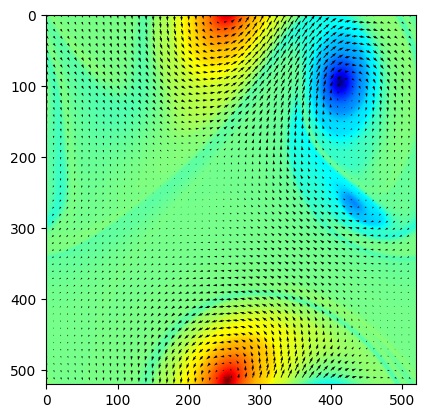

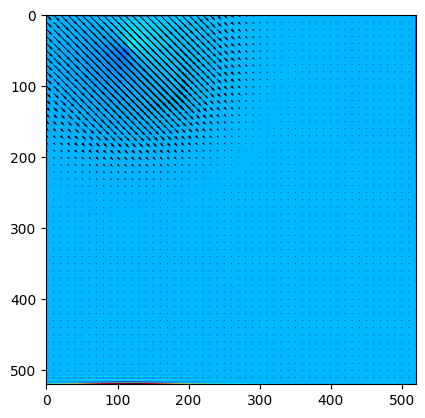

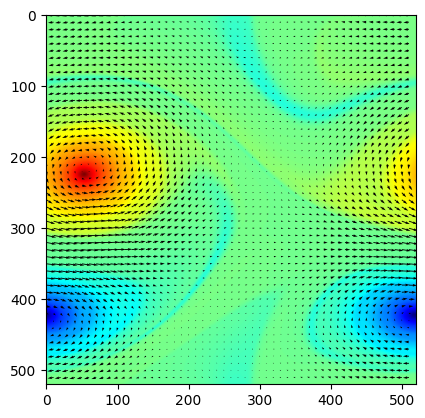

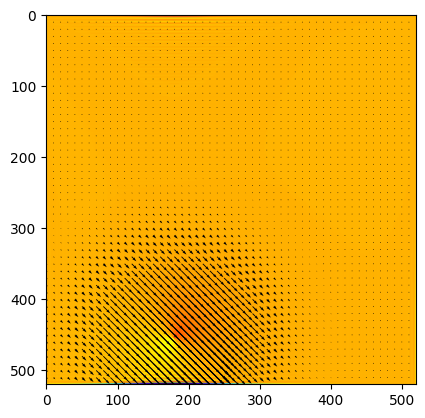

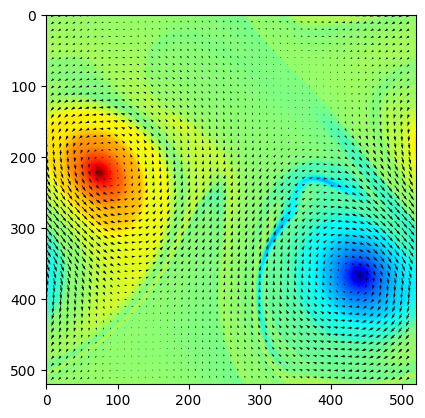

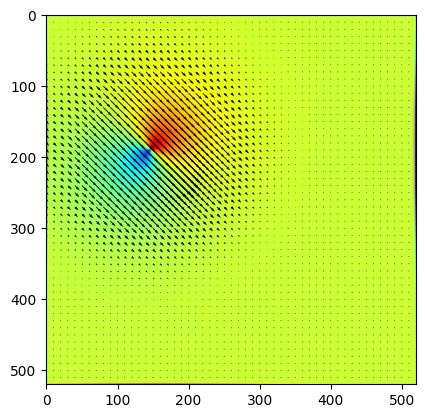

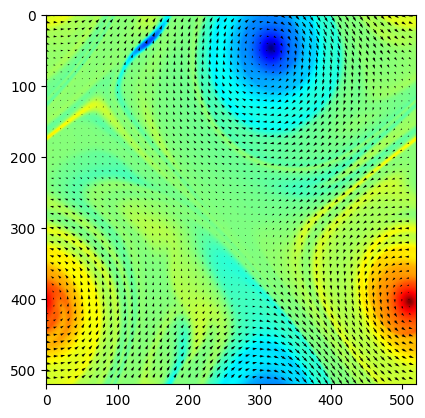

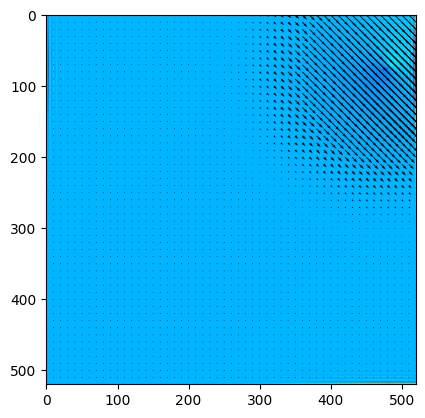

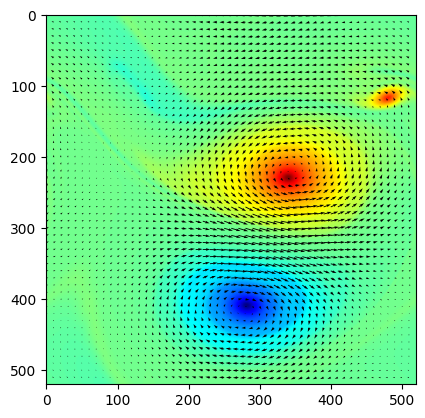

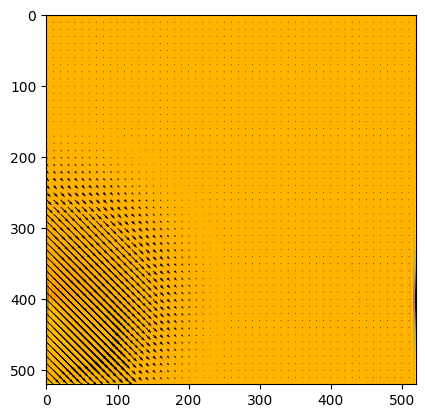

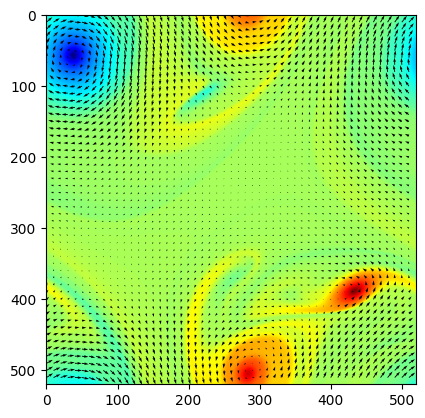

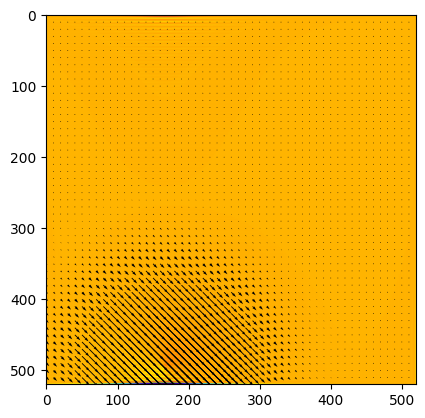

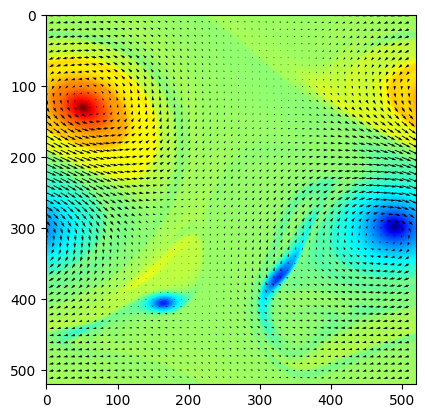

In [678]:

# progress_in_time(U, V, 0)
generate_validation_set(10)